In [2]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import sys
sys.path.append('../')
from utils import *

## Prepro: change names to numbers

In [3]:
train_feats = pd.read_csv('../feature_eng/output/train_double_corr_786feats.csv')
train_score = pd.read_csv('../data/train_scores.csv')

# train_feats_first10min = pd.read_csv('../../feature_eng/output/train_double_corr_first_10min_786feats.csv')
# train_feats_second10min = pd.read_csv('../../feature_eng/output/train_double_corr_second_10min_786feats.csv')
# train_feats = train_feats.merge(train_feats_first10min, on='id', how='left')
# train_feats = train_feats.merge(train_feats_second10min, on='id', how='left')

if 'score' not in train_feats.columns:
    train_feats = pd.merge(train_feats, train_score, on='id', how='left')

train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_feats['score'])

score_transformed = le.transform(train_feats['score'])

## Keep columns

In [4]:
# Options:
# "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features"
# "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes"
# "punctuation", "key_mouse", "time_feat", "fft", "avg_event_per_minute", 
# "avg_char_deletion_per_minute", "avg_char_insert_per_minute"
# "IKI_word", "IKI_sentence", "IKI_paragraph", "latencies", "IWD"
# 'idle'

endings_to_keep = ["-count_bursts", "-word_sent_parag_agg", "time_gaps", "cursor_word_changes", "-IWD", '-idle']
endings_to_keep += ["id"]

dir_to_save = "xgb12"
stratification = True
n_jobs = -1
noise = True
iterations = 5
n_splits = 4

try:
    os.mkdir(dir_to_save)
except:
    print('Already exists')
    sys.exit()

# cols_to_keep = [col for col in train_feats.columns if col.endswith(tuple(endings_to_keep)) or col in ['id', 'score']]
cols_to_keep = [col for col in train_feats.columns if any(ending in col for ending in endings_to_keep) or col in ['id', 'score']]

with open(f'{dir_to_save}/feature_list.pkl', 'wb') as f:
    pickle.dump(cols_to_keep, f)

train_feats = train_feats[cols_to_keep]
print(len(train_feats.columns)-2)

593


In [5]:
counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

In [6]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [8]:
from xgboost                 import XGBRegressor
from catboost                import Pool
from catboost                import CatBoostRegressor
from lightgbm                import LGBMRegressor
from sklearn.svm             import SVR
from sklearn.naive_bayes     import GaussianNB
from sklearn.tree            import DecisionTreeRegressor
from mlxtend.regressor       import StackingRegressor
from sklearn.linear_model    import LinearRegression, BayesianRidge, ElasticNet, Lasso, \
                                    LassoLarsIC, Ridge, RidgeCV, LassoCV, LassoLarsCV, SGDRegressor
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, train_test_split, \
                                    GridSearchCV, RandomizedSearchCV
from sklearn.ensemble        import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics         import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.kernel_ridge    import KernelRidge
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import RobustScaler, PolynomialFeatures
from sklearn.base            import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [11]:
target = train_feats[target_col]
untarget_data = train_feats.drop(target_col + drop_cols, axis=1).fillna(train_feats.median())

C:\Users\luis.pinto1\AppData\Local\Temp\ipykernel_14804\4110431419.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  untarget_data = train_feats.drop(target_col + drop_cols, axis=1).fillna(train_feats.median())


In [13]:
# 5 Fold Cross validation
kf = KFold(n_splits=5, shuffle=True)
cv_scores, cv_std = [], []

# Creation of the RMSE metric:
def rmse(model):
    return np.sqrt(-cross_val_score(model, untarget_data, target, scoring="neg_mean_squared_error", cv=kf))

def apply_learning_algorithm(model):
    score = rmse(model)
    cv_scores.append(score.mean())
    cv_std.append(score.std())

In [14]:
models = [
    Ridge(alpha = 10),
    LassoCV(alphas = [1, 0.1, 0.001, 0.0005]),
    XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1),
    LinearRegression(),                               # Linear Regression
    BayesianRidge(compute_score=True),     # Bayesian Ridge Regression
    LGBMRegressor(                         # Light Gradient Boost Regressor
                      objective='regression',
                      num_leaves=5,
                      learning_rate=0.05, 
                      n_estimators=720,
                      max_bin = 55, 
                      bagging_fraction = 0.8,
                      bagging_freq = 5, 
                      feature_fraction = 0.2319,
                      feature_fraction_seed=9, 
                      bagging_seed=9,
                      min_data_in_leaf =6, 
                      min_sum_hessian_in_leaf = 11),
    SVR(kernel='rbf', C=1000000, epsilon=0.001),                                 # Support Vector Regression
    DecisionTreeRegressor(),               # Decision Tree Regressor
    RandomForestRegressor(n_estimators=1000),               # Random Forest Regressor
    XGBRegressor(                          # XGB Regressor
                      colsample_bytree=0.4603, 
                      gamma=0.0468, 
                      learning_rate=0.05, 
                      max_depth=3, 
                      min_child_weight=1.7817, 
                      n_estimators=2200,
                      reg_alpha=0.4640, 
                      reg_lambda=0.8571,
                      subsample=0.5213),
    GradientBoostingRegressor(             # Gradient Boost Regressor
                      n_estimators=3000, 
                      learning_rate=0.05,
                      max_depth=4, 
                      max_features='sqrt',
                      min_samples_leaf=15, 
                      min_samples_split=10, 
                      loss='huber'),
    CatBoostRegressor(),                   # Cat Boost Regressor
    StackingRegressor(                     # Stacked Regressor
                      regressors=(CatBoostRegressor(),
                                  LinearRegression(),
                                  BayesianRidge(),
                                  GradientBoostingRegressor()),
                                  meta_regressor = CatBoostRegressor(),
                                  use_features_in_secondary = True),
    make_pipeline(                         # Lasso Regression
                      RobustScaler(), 
                      Lasso(alpha =0.0005)),
    make_pipeline(                         # Elastic Net Regression
                      RobustScaler(), 
                      ElasticNet(alpha=0.0005, l1_ratio=.9)),
    KernelRidge(                           # Kernel Ridge Regression
                      alpha=0.6, 
                      kernel='polynomial', 
                      degree=2, 
                      coef0=2.5),
]

In [15]:
model_names = [
    'Ridge',
    'LassoCV', 
    'XGBRegressor',
    'LinearRegression',
    'BayesianRidge', 
    'LGBMRegressor',
    'SupportVectorRegressor', 
    'DecisionTreeRegressor',
    'RandomForestRegressor', 
    'XGBRegressor', 
    'GradientBoostingRegressor', 
    'CatBoostRegressor',
    'StackingRegressor',
    'LassoRegressor',
    'ElasticNetRegressor',
    'KernelRidgeRegressor'
]

In [16]:
for model in models:
    apply_learning_algorithm(model)

c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.14468e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.13816e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.19166e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.1711e-18): result may not be accurate

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\v

Learning rate set to 0.045595
0:	learn: 1.0052748	total: 173ms	remaining: 2m 53s
1:	learn: 0.9838782	total: 190ms	remaining: 1m 34s
2:	learn: 0.9632450	total: 206ms	remaining: 1m 8s
3:	learn: 0.9432602	total: 223ms	remaining: 55.6s
4:	learn: 0.9256877	total: 240ms	remaining: 47.8s
5:	learn: 0.9082277	total: 272ms	remaining: 45.1s
6:	learn: 0.8927611	total: 290ms	remaining: 41.1s
7:	learn: 0.8765017	total: 306ms	remaining: 37.9s
8:	learn: 0.8603879	total: 322ms	remaining: 35.5s
9:	learn: 0.8467119	total: 339ms	remaining: 33.6s
10:	learn: 0.8341651	total: 356ms	remaining: 32s
11:	learn: 0.8218410	total: 372ms	remaining: 30.6s
12:	learn: 0.8102522	total: 388ms	remaining: 29.5s
13:	learn: 0.7995999	total: 405ms	remaining: 28.5s
14:	learn: 0.7888124	total: 422ms	remaining: 27.7s
15:	learn: 0.7786208	total: 438ms	remaining: 26.9s
16:	learn: 0.7684921	total: 454ms	remaining: 26.3s
17:	learn: 0.7587734	total: 472ms	remaining: 25.7s
18:	learn: 0.7512823	total: 488ms	remaining: 25.2s
19:	learn: 

c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2:	learn: 0.9635245	total: 52.6ms	remaining: 17.5s
3:	learn: 0.9429687	total: 71.2ms	remaining: 17.7s
4:	learn: 0.9228168	total: 95.5ms	remaining: 19s
5:	learn: 0.9047698	total: 113ms	remaining: 18.7s
6:	learn: 0.8896725	total: 130ms	remaining: 18.5s
7:	learn: 0.8745843	total: 148ms	remaining: 18.3s
8:	learn: 0.8592240	total: 166ms	remaining: 18.2s
9:	learn: 0.8455246	total: 184ms	remaining: 18.2s
10:	learn: 0.8318836	total: 201ms	remaining: 18.1s
11:	learn: 0.8197384	total: 221ms	remaining: 18.2s
12:	learn: 0.8079589	total: 240ms	remaining: 18.2s
13:	learn: 0.7971358	total: 258ms	remaining: 18.2s
14:	learn: 0.7865475	total: 276ms	remaining: 18.1s
15:	learn: 0.7767305	total: 294ms	remaining: 18.1s
16:	learn: 0.7667453	total: 313ms	remaining: 18.1s
17:	learn: 0.7580117	total: 332ms	remaining: 18.1s
18:	learn: 0.7495453	total: 350ms	remaining: 18.1s
19:	learn: 0.7411859	total: 374ms	remaining: 18.3s
20:	learn: 0.7329216	total: 392ms	remaining: 18.3s
21:	learn: 0.7259162	total: 410ms	rema

c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.045598
0:	learn: 1.0021950	total: 20.2ms	remaining: 20.2s
1:	learn: 0.9796674	total: 37.5ms	remaining: 18.7s
2:	learn: 0.9579354	total: 53.9ms	remaining: 17.9s
3:	learn: 0.9378281	total: 70.6ms	remaining: 17.6s
4:	learn: 0.9192214	total: 86.9ms	remaining: 17.3s
5:	learn: 0.9012597	total: 103ms	remaining: 17.1s
6:	learn: 0.8844509	total: 119ms	remaining: 16.9s
7:	learn: 0.8683171	total: 136ms	remaining: 16.9s
8:	learn: 0.8537651	total: 153ms	remaining: 16.9s
9:	learn: 0.8405005	total: 170ms	remaining: 16.8s
10:	learn: 0.8280117	total: 186ms	remaining: 16.8s
11:	learn: 0.8153372	total: 203ms	remaining: 16.7s
12:	learn: 0.8039578	total: 220ms	remaining: 16.7s
13:	learn: 0.7930952	total: 252ms	remaining: 17.8s
14:	learn: 0.7828156	total: 270ms	remaining: 17.7s
15:	learn: 0.7726269	total: 288ms	remaining: 17.7s
16:	learn: 0.7626622	total: 304ms	remaining: 17.6s
17:	learn: 0.7545900	total: 321ms	remaining: 17.5s
18:	learn: 0.7460932	total: 337ms	remaining: 17.4s
19:	le

c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.045598
0:	learn: 0.9933626	total: 18.5ms	remaining: 18.5s
1:	learn: 0.9736331	total: 35.5ms	remaining: 17.7s
2:	learn: 0.9531669	total: 52.6ms	remaining: 17.5s
3:	learn: 0.9353724	total: 69.3ms	remaining: 17.3s
4:	learn: 0.9183316	total: 86.5ms	remaining: 17.2s
5:	learn: 0.9013591	total: 103ms	remaining: 17.1s
6:	learn: 0.8852424	total: 120ms	remaining: 17.1s
7:	learn: 0.8700993	total: 136ms	remaining: 16.9s
8:	learn: 0.8552626	total: 153ms	remaining: 16.8s
9:	learn: 0.8415457	total: 169ms	remaining: 16.7s
10:	learn: 0.8298094	total: 185ms	remaining: 16.7s
11:	learn: 0.8173388	total: 203ms	remaining: 16.8s
12:	learn: 0.8054243	total: 222ms	remaining: 16.9s
13:	learn: 0.7945540	total: 240ms	remaining: 16.9s
14:	learn: 0.7850344	total: 259ms	remaining: 17s
15:	learn: 0.7761147	total: 277ms	remaining: 17.1s
16:	learn: 0.7660543	total: 295ms	remaining: 17s
17:	learn: 0.7574346	total: 312ms	remaining: 17s
18:	learn: 0.7503462	total: 329ms	remaining: 17s
19:	learn: 0.7

c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.045598
0:	learn: 0.9983052	total: 19.8ms	remaining: 19.8s
1:	learn: 0.9771428	total: 39.3ms	remaining: 19.6s
2:	learn: 0.9582251	total: 57ms	remaining: 18.9s
3:	learn: 0.9397097	total: 74.2ms	remaining: 18.5s
4:	learn: 0.9214069	total: 92.5ms	remaining: 18.4s
5:	learn: 0.9049731	total: 112ms	remaining: 18.5s
6:	learn: 0.8889351	total: 130ms	remaining: 18.4s
7:	learn: 0.8725347	total: 148ms	remaining: 18.3s
8:	learn: 0.8578198	total: 165ms	remaining: 18.2s
9:	learn: 0.8434413	total: 182ms	remaining: 18.1s
10:	learn: 0.8308884	total: 200ms	remaining: 18s
11:	learn: 0.8181358	total: 217ms	remaining: 17.9s
12:	learn: 0.8078047	total: 236ms	remaining: 17.9s
13:	learn: 0.7967106	total: 254ms	remaining: 17.9s
14:	learn: 0.7864633	total: 271ms	remaining: 17.8s
15:	learn: 0.7765132	total: 289ms	remaining: 17.7s
16:	learn: 0.7670079	total: 305ms	remaining: 17.7s
17:	learn: 0.7575296	total: 322ms	remaining: 17.5s
18:	learn: 0.7497474	total: 338ms	remaining: 17.5s
19:	learn:

c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate set to 0.045598
0:	learn: 1.0058318	total: 20ms	remaining: 20s
1:	learn: 0.9837789	total: 37.1ms	remaining: 18.5s
2:	learn: 0.9628250	total: 54ms	remaining: 18s
3:	learn: 0.9439211	total: 71.1ms	remaining: 17.7s
4:	learn: 0.9251464	total: 87.6ms	remaining: 17.4s
5:	learn: 0.9070836	total: 105ms	remaining: 17.4s
6:	learn: 0.8900811	total: 123ms	remaining: 17.4s
7:	learn: 0.8742000	total: 140ms	remaining: 17.4s
8:	learn: 0.8590631	total: 157ms	remaining: 17.3s
9:	learn: 0.8440409	total: 174ms	remaining: 17.2s
10:	learn: 0.8308977	total: 190ms	remaining: 17.1s
11:	learn: 0.8177922	total: 208ms	remaining: 17.1s
12:	learn: 0.8057359	total: 225ms	remaining: 17.1s
13:	learn: 0.7936362	total: 242ms	remaining: 17.1s
14:	learn: 0.7831428	total: 259ms	remaining: 17s
15:	learn: 0.7726920	total: 276ms	remaining: 17s
16:	learn: 0.7629625	total: 293ms	remaining: 17s
17:	learn: 0.7536961	total: 310ms	remaining: 16.9s
18:	learn: 0.7448690	total: 327ms	remaining: 16.9s
19:	learn: 0.7369468

c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e+02, tolerance: 2.082e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+02, tolerance: 2.025e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

In [27]:
final_cv_score = pd.DataFrame(model_names, columns = ['Regressors'])
final_cv_score['RMSE_mean'] = cv_scores
final_cv_score['RMSE_std'] = cv_std
final_cv_score.sort_values(by=['RMSE_mean'])

,Regressors,RMSE_mean,RMSE_std
11,CatBoostRegressor,0.617984,0.016652
2,XGBRegressor,0.619471,0.033055
5,LGBMRegressor,0.623628,0.013193
12,StackingRegressor,0.626485,0.014090
8,RandomForestRegressor,0.629366,0.025752
10,GradientBoostingRegressor,0.637232,0.031232
9,XGBRegressor,0.637518,0.013348
1,LassoCV,0.700832,0.044997
4,BayesianRidge,0.713288,0.016969
13,LassoRegressor,0.716138,0.012969


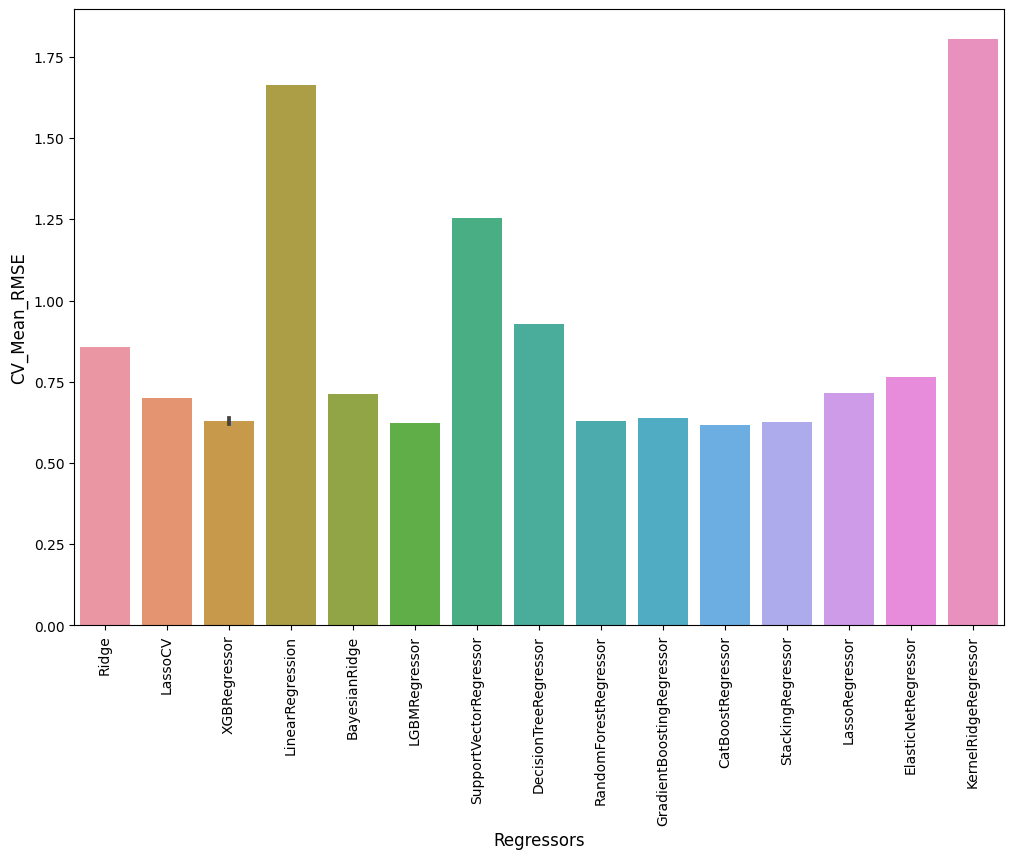

In [28]:
plt.figure(figsize = (12,8))
sns.barplot(x='Regressors', y='RMSE_mean', data=final_cv_score)
plt.xlabel('Regressors', fontsize = 12)
plt.ylabel('CV_Mean_RMSE', fontsize = 12)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Train-Test split the data
x_train, x_validation, y_train, y_validation = \
            train_test_split(untarget_data, target, test_size = 0.1)

In [ ]:
best_regressor_name = final_cv_score.sort_values(by=['RMSE_mean']).head(1)['Regressors'].iloc[0]
best_regressor = models[model_names.index(best_regressor_name)]
best_regressor

In [ ]:
# The Best Regressor
best_model = best_regressor.fit(x_train, y_train)

In [ ]:
# Creation of the RMSE metric:    
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
pred = best_model.predict(x_validation)
score = rmse(y_validation, pred)
score

In [ ]:
print('OOF metric XGB = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   OOF_SCORE,
                                                                   squared=False)))

OOF metric XGB = 0.60837


In [ ]:
import pickle

with open(f'{dir_to_save}/OOF_base_xgb.pkl', 'wb') as f:
    pickle.dump(OOF_SCORE, f)

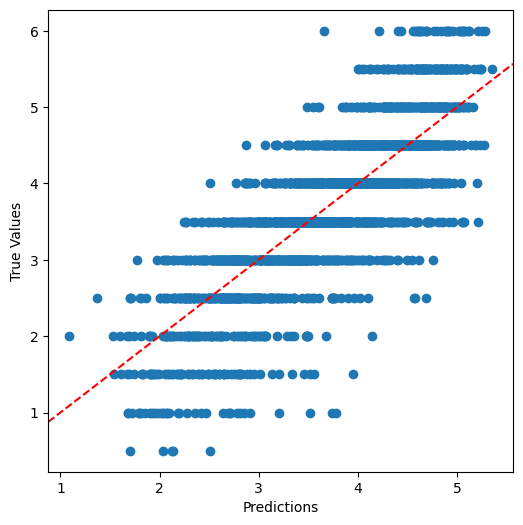

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(OOF_SCORE, train_feats['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()